## Packages

In [128]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [129]:
def load_data(path):
    train_dataset = h5py.File(path+'/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File(path+'/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

## Dataset

To be familiar with the dataset, load the data by running the cell below.

In [130]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data(r"C:\Users\Ogrenci\Desktop\dataset") # you need to change your dataset path

The following code will show you an image in the dataset. Feel free to change the index and re-run the cell multiple times to see other images. 

y = 0. It's a non-cat picture.


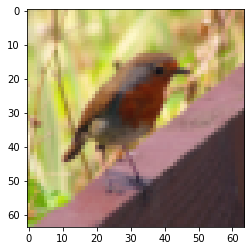

In [131]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [132]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [133]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


In [134]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [174]:
def initialize_parameters_deep(layers_dims):
    
    np.random.seed(1)
    parameters = {}

    parameters["W1"] = np.random.randn(layers_dims[1], layers_dims[0])*0.01
    parameters["b1"] = np.zeros((layers_dims[1], 1))
    parameters["W2"] = np.random.randn(layers_dims[2], layers_dims[1])*0.01
    parameters["b2"] = np.zeros((layers_dims[2], 1))
    
    return parameters

In [175]:
def linear_activation_forward(X,parameters):

    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    def relu(x):
        s = np.maximum(0,x)
        return s
    
    def sigmoid(x):
        s = 1/(1+np.exp(-x))
        return s

    Z1 = np.dot(W1, X) + b1
    A = relu(Z1)
    Z2=np.dot(W2, A) + b2
    AL=sigmoid(Z2)
    
    cache = (Z1, A, W1, b1, Z2, AL, W2, b2)
    
    return AL , cache

In [176]:
def compute_cost(AL, Y):

    m = Y.shape[1]
    
    logprobs = np.multiply(-np.log(AL),Y) + np.multiply(-np.log(1 - AL), 1 - Y)
    cost = 1./m * np.nansum(logprobs)
       
    return cost

In [177]:
def linear_activation_backward(X,cost,cache,Y):

    m = X.shape[1]
    (Z1, A, W1, b1, Z2, AL, W2, b2) = cache
    
    dZ2 = AL - Y
    dW2 = 1./m * np.dot(dZ2, A.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA, np.float64(A > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    grads = {"dZ2": dZ2, "dW2": dW2, "db2": db2,"dA": dA, "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return grads

In [178]:
def update_parameters(parameters, grads, learning_rate):

    n = len(parameters) // 2

    for k in range(n):
        parameters["W" + str(k+1)] = parameters["W" + str(k+1)] - learning_rate * grads["dW" + str(k+1)]
        parameters["b" + str(k+1)] = parameters["b" + str(k+1)] - learning_rate * grads["db" + str(k+1)]
    
    return parameters

In [189]:
def predict(test_x, test_y, parameters):

    m = test_x.shape[1]
    p = np.zeros((1,m))
    

    AL, caches = linear_activation_forward(test_x, parameters)
    
    for i in range(0, AL.shape[1]):
        if AL[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    Accuracy= str(np.mean((p[0,:] == test_y[0,:]))*100)
    
    return Accuracy


In [190]:
def plot_loss(costs):
    plt.plot(costs)
    plt.show()
    

In [191]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000):

    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    ### START CODE HERE ### (≈ 1 line of code)
    parameters = initialize_parameters_deep(layers_dims)
    ### END CODE HERE ###
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        ### START CODE HERE ### 
        AL,cache = linear_activation_forward(X,parameters)
        ### END CODE HERE ###
        
        # Compute cost
        ### START CODE HERE ### 
        cost = compute_cost(AL, Y)
        ### END CODE HERE ###
        
        
        # Backward propagation.
        ### START CODE HERE ### 
        grads = linear_activation_backward(X,cost,cache,Y)
        ### END CODE HERE ###

        
        # Update parameters.
        ### START CODE HERE ### 
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###
        
        # Print the cost every 100 training example
        if i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0:
            costs.append(cost)
    
    predicts= predict(test_x, test_y, parameters)
    print(f"Your accuracy:  %{predicts}")
    plot_loss(costs)
    
    return parameters, costs

In [192]:
def main():
    two_layer_model(train_x, train_y, layers_dims, learning_rate = 0.0075, num_iterations = 3000)

Cost after iteration 0: 0.693049735659989
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912677
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605747
Cost after iteration 500: 0.5158304772764729
Cost after iteration 600: 0.47549013139433266
Cost after iteration 700: 0.4339163151225749
Cost after iteration 800: 0.400797753620389
Cost after iteration 900: 0.3580705011323798
Cost after iteration 1000: 0.3394281538366412
Cost after iteration 1100: 0.3052753636196264
Cost after iteration 1200: 0.2749137728213018
Cost after iteration 1300: 0.24681768210614846
Cost after iteration 1400: 0.19850735037466108
Cost after iteration 1500: 0.1744831811255665
Cost after iteration 1600: 0.17080762978095573
Cost after iteration 1700: 0.1130652456216474
Cost after iteration 1800: 0.09629426845937158
Cost after iteration 1900: 0.08342617959726861
Cost after iteration 2000: 0.07439078704319078
Cost after iteration 2100: 0.066307481322

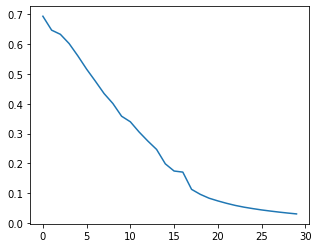

In [193]:
main()